# Task 5: Time Series Clustering

ECG time series clustering using Lead II signals.

**Workflow:**
1. Import preprocessed time series data from notebook 3.1 (already includes offset removal, amplitude scaling/z-normalization, trend removal, and noise filtering)
2. Construct PAA (Piecewise Aggregate Approximation) feature vectors
3. Compare KMeans, hierarchical clustering, and DBSCAN algorithms

**Note:** Preprocessing (steps 1-2 from the original workflow) is done once in notebook 3.1 and exported. This notebook imports the preprocessed data to avoid redundant computation.

Clustering uses only time series features, not tabular patient data.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy import stats
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

base_path = Path.cwd()
if base_path.name == "code":
    base_path = base_path.parent

data_path = base_path / "Data"
code_path = base_path / "code"

print(f"Working directory: {base_path}")
print(f"Data path: {data_path}")

# Import preprocessed time series data (preprocessed in notebook 3.1)
# This replaces the raw data loading to avoid redundant preprocessing
preprocessed_file = data_path / 'preprocessed_time_series.pkl'
print(f"\nLoading preprocessed time series data from: {preprocessed_file}")

with open(preprocessed_file, 'rb') as f:
    preprocessed_data = pickle.load(f)

# Extract data
subject_ids = preprocessed_data['subject_ids']
X_ts = preprocessed_data['preprocessed_equal_length']  # Shape: (n_subjects, 100)

print(f"\nLoaded preprocessed time series data:")
print(f"  - Number of subjects: {len(subject_ids):,}")
print(f"  - Time series shape: {X_ts.shape}")
print(f"  - Preprocessing steps: {', '.join(preprocessed_data['metadata']['preprocessing_steps'])}")

# For compatibility with existing code, create patient_ids variable
patient_ids = subject_ids

print(f"\nFinal number of patients used: {len(patient_ids)}")
print(f"Time series matrix shape (patients x time): {X_ts.shape}")

Working directory: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi
Data path: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data

Loading preprocessed time series data from: /Users/alexandermittet/LOCAL documents/DAD local/data_analytics_4_health_unipi/Data/preprocessed_time_series.pkl

Loaded preprocessed time series data:
  - Number of subjects: 1,786
  - Time series shape: (1786, 100)
  - Preprocessing steps: offset_translation_removal, amplitude_scaling_z_normalization, linear_trend_removal, noise_filtering_moving_average

Final number of patients used: 1786
Time series matrix shape (patients x time): (1786, 100)


## Normalized Time Series

Resampled to 100 time points and z-normalized (mean=0, std=1).

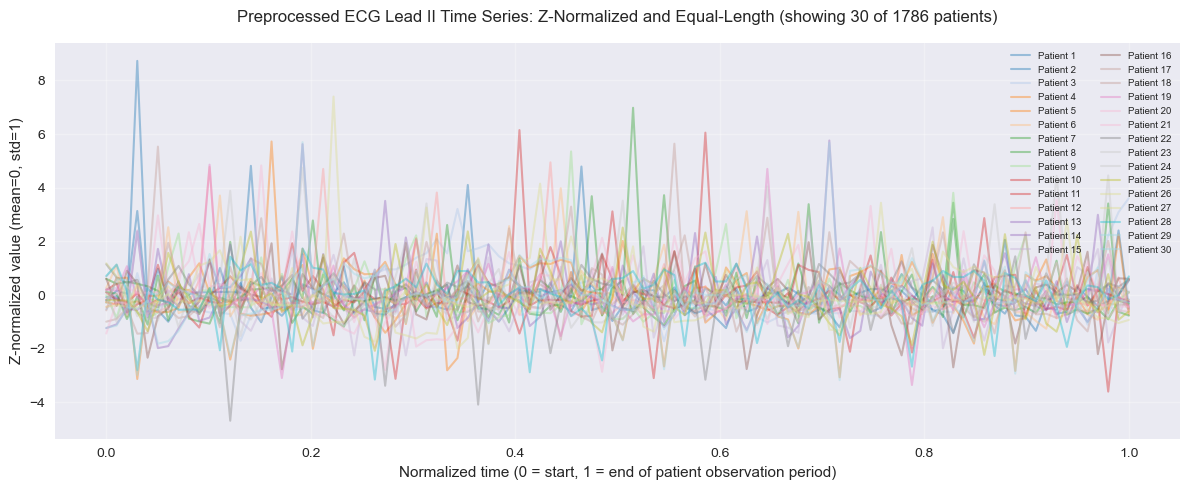

In [10]:
# Visualize a subset of normalized time series
plt.figure(figsize=(12, 5))
n_show = min(30, X_ts.shape[0])
colors = plt.cm.tab20(np.linspace(0, 1, n_show))
for i in range(n_show):
    plt.plot(np.linspace(0.0, 1.0, X_ts.shape[1]), X_ts[i], alpha=0.4, linewidth=1.5, 
             color=colors[i], label=f"Patient {i+1}")
plt.title(f"Preprocessed ECG Lead II Time Series: Z-Normalized and Equal-Length (showing {n_show} of {X_ts.shape[0]} patients)", fontsize=12, pad=15)
plt.xlabel("Normalized time (0 = start, 1 = end of patient observation period)", fontsize=11)
plt.ylabel("Z-normalized value (mean=0, std=1)", fontsize=11)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', fontsize=7, ncol=2, framealpha=0.9)
plt.tight_layout()
plt.show()

In [11]:
# PAA feature extraction

def paa(series, n_segments):
    series = np.asarray(series)
    n = len(series)
    if n_segments > n:
        raise ValueError("n_segments must be <= length of series")

    idx = np.linspace(0, n, n_segments + 1, dtype=int)
    segments = []
    for i in range(n_segments):
        start = idx[i]
        end = idx[i + 1]
        seg_mean = series[start:end].mean()
        segments.append(seg_mean)
    return np.array(segments)

n_segments = 20  # PAA dimensionality (can adjust)
X_paa = np.vstack([paa(ts, n_segments) for ts in X_ts])

print(f"PAA feature matrix shape (patients x segments): {X_paa.shape}")

PAA feature matrix shape (patients x segments): (1786, 20)


## PAA Features

PAA reduces each time series to 20 segments (mean values). Reduces dimensionality from 100 to 20 while preserving shape.

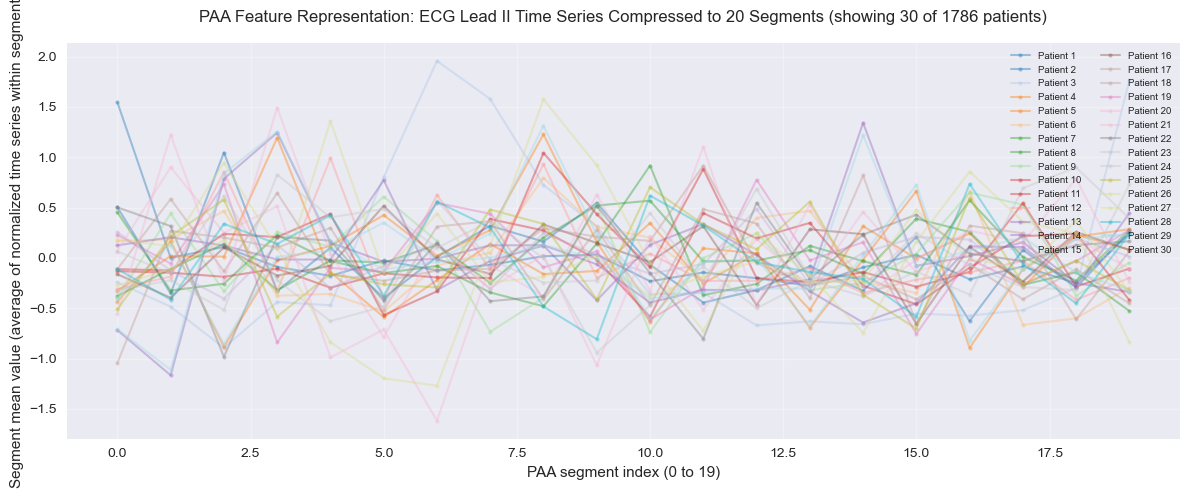

In [12]:
# Visualize PAA feature representation
plt.figure(figsize=(12, 5))
n_show = min(30, X_paa.shape[0])
colors = plt.cm.tab20(np.linspace(0, 1, n_show))
for i in range(n_show):
    plt.plot(range(n_segments), X_paa[i], alpha=0.4, linewidth=1.5, marker='o', markersize=3, 
             color=colors[i], label=f"Patient {i+1}")
plt.title(f"PAA Feature Representation: ECG Lead II Time Series Compressed to {n_segments} Segments (showing {n_show} of {X_paa.shape[0]} patients)", fontsize=12, pad=15)
plt.xlabel(f"PAA segment index (0 to {n_segments-1})", fontsize=11)
plt.ylabel("Segment mean value (average of normalized time series within segment)", fontsize=11)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', fontsize=7, ncol=2, framealpha=0.9)
plt.tight_layout()
plt.show()

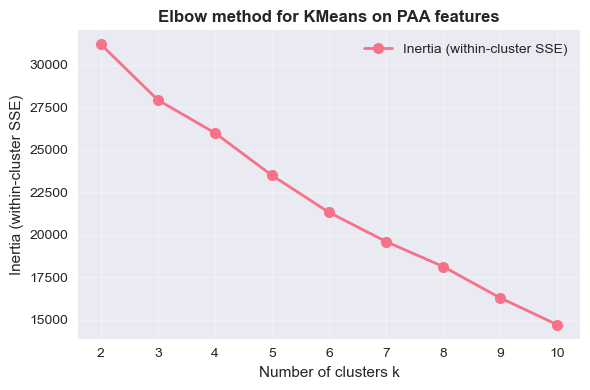

In [13]:
# KMeans clustering with elbow method

scaler = StandardScaler()
X_paa_scaled = scaler.fit_transform(X_paa)

ks = range(2, 11)
inertias = []

for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_paa_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(list(ks), inertias, marker="o", linewidth=2, markersize=8, label="Inertia (within-cluster SSE)")
plt.xlabel("Number of clusters k", fontsize=11)
plt.ylabel("Inertia (within-cluster SSE)", fontsize=11)
plt.title("Elbow method for KMeans on PAA features", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

## Clustering

All clustering algorithms use only PAA features. Tabular data used later for cluster interpretation only.

0    131
1    735
2    292
3    560
4     68
Name: count, dtype: int64


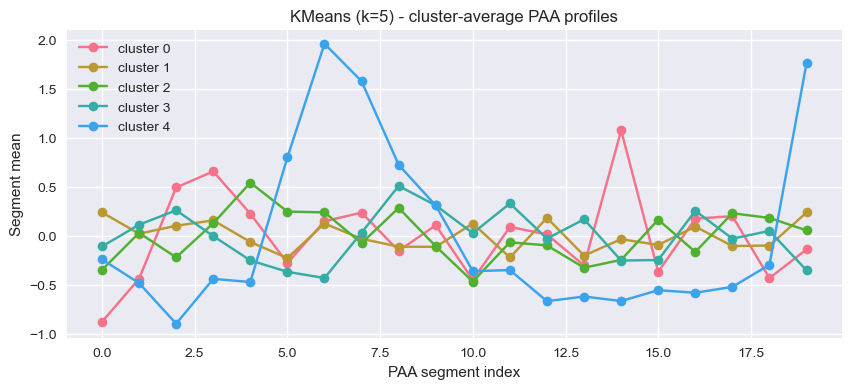

Silhouette score (KMeans, k=5): 0.210


In [14]:
# Choose k after inspecting the elbow plot
k_kmeans = 5  # adjust if elbow suggests a different value

kmeans = KMeans(n_clusters=k_kmeans, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_paa_scaled)

print(pd.Series(kmeans_labels).value_counts().sort_index())


def plot_cluster_profiles(X_paa, labels, title, alpha=1.0, legend_text=None):
    """
    Plot cluster average PAA profiles.
    
    Parameters:
    -----------
    X_paa : array-like
        PAA feature matrix
    labels : array-like
        Cluster labels
    title : str
        Plot title
    alpha : float, default=1.0
        Opacity of the plot lines (0.0 to 1.0)
    legend_text : str or None, default=None
        Custom legend text. If None, shows individual cluster labels.
    """
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    plt.figure(figsize=(10, 4))
    for lab in unique_labels:
        cluster_mean = X_paa[labels == lab].mean(axis=0)
        plt.plot(range(n_segments), cluster_mean, marker="o", label=f"cluster {lab}", alpha=alpha)
    
    plt.xlabel("PAA segment index")
    plt.ylabel("Segment mean")
    plt.title(title)
    
    if legend_text is not None:
        # Use custom legend text
        plt.legend([legend_text], loc='best', fontsize=9)
    else:
        # Use default individual cluster labels
        plt.legend()
    
    plt.grid(True)
    plt.show()

plot_cluster_profiles(X_paa, kmeans_labels, f"KMeans (k={k_kmeans}) - cluster-average PAA profiles")

sil_kmeans = silhouette_score(X_paa_scaled, kmeans_labels)
print(f"Silhouette score (KMeans, k={k_kmeans}): {sil_kmeans:.3f}")

## Cluster Profiling

Patient characteristics by cluster (age, gender, diagnosis).

In [15]:
# Load heart diagnoses data for cluster interpretation
df_heart = pd.read_csv(data_path / "heart_diagnoses_1.csv")
df_heart["charttime"] = pd.to_datetime(df_heart["charttime"], errors="coerce")

print(f"Heart Diagnoses loaded: {len(df_heart):,} rows")
print(f"Unique subjects: {df_heart['subject_id'].nunique():,}")

# Extract patient metadata and merge with cluster labels
# Get unique patient metadata from heart_diagnoses (age, gender, diagnosis)
patient_metadata = df_heart[
    ['subject_id', 'gender', 'age', 'icd_code', 'long_title']
].drop_duplicates(subset='subject_id').copy()

# Create a dataframe with patient_id and cluster label
cluster_df = pd.DataFrame({
    'subject_id': patient_ids,
    'cluster': kmeans_labels
})

# Merge cluster labels with patient metadata
cluster_profiles = cluster_df.merge(patient_metadata, on='subject_id', how='left')

print(f"Patients with cluster labels: {len(cluster_df)}")
print(f"Patients with metadata: {cluster_profiles['gender'].notna().sum()}")
print(f"\nCluster sizes:")
print(cluster_profiles['cluster'].value_counts().sort_index())
cluster_profiles.head(10)

Heart Diagnoses loaded: 4,864 rows
Unique subjects: 4,392
Patients with cluster labels: 1786
Patients with metadata: 1184

Cluster sizes:
cluster
0    131
1    735
2    292
3    560
4     68
Name: count, dtype: int64


,subject_id,cluster,gender,age,icd_code,long_title
0,10000980,1,F,75.0,I50,Heart failure
1,10004457,1,M,66.0,I35,Nonrheumatic aortic valve disorders
2,10007058,4,M,48.0,I21,Acute myocardial infarction
3,10018684,2,M,48.0,I48,Atrial fibrillation and flutter
4,10044096,1,M,53.0,I21,Acute myocardial infarction
5,10051074,3,F,71.0,I21,Acute myocardial infarction
6,10059952,1,M,73.0,I21,Acute myocardial infarction
7,10064049,3,M,70.0,I50,Heart failure
8,10075925,2,F,54.0,I50,Heart failure
9,10076616,3,M,64.0,I47,Paroxysmal tachycardia


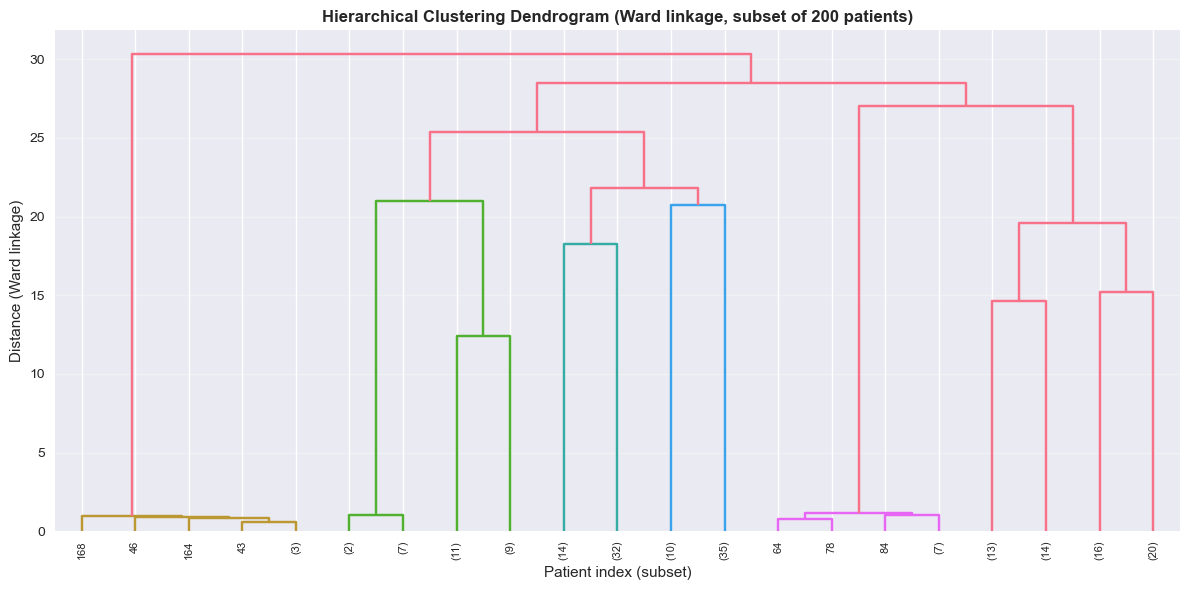

In [16]:
# Optional: Dendrogram visualization (on a subset for clarity)
from scipy.cluster.hierarchy import linkage, dendrogram

subset_size = min(200, X_paa_scaled.shape[0])
X_sub = X_paa_scaled[:subset_size]

Z = linkage(X_sub, method="ward")

plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode="level", p=4, leaf_rotation=90, leaf_font_size=8)
plt.title(f"Hierarchical Clustering Dendrogram (Ward linkage, subset of {subset_size} patients)", fontsize=12, fontweight='bold')
plt.xlabel("Patient index (subset)", fontsize=11)
plt.ylabel("Distance (Ward linkage)", fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

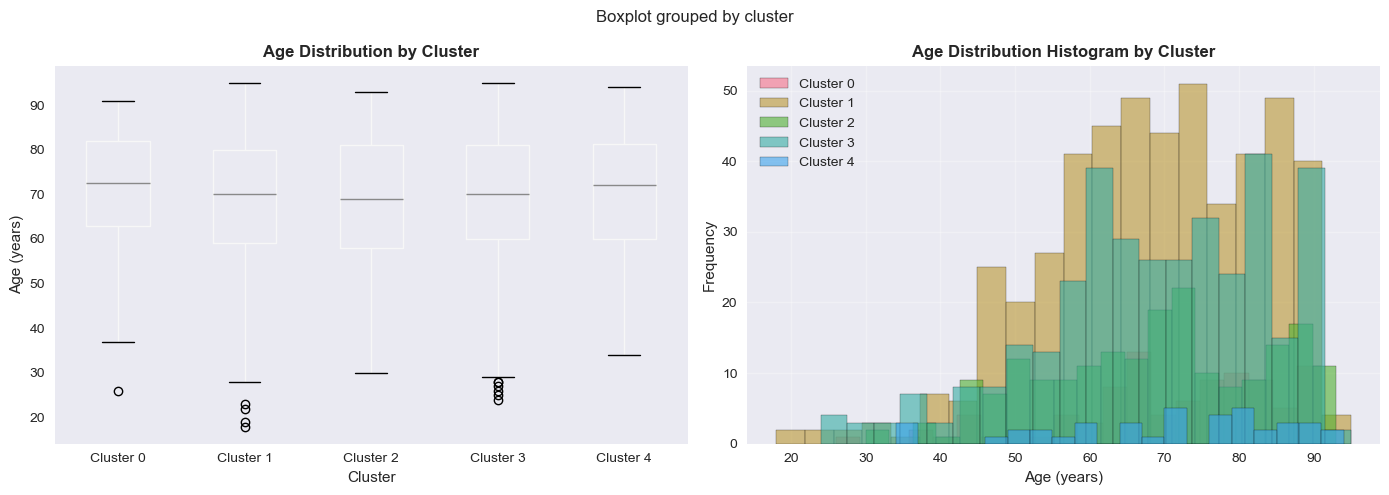

Age Statistics by Cluster:
         count       mean        std   min   25%   50%    75%   max
cluster                                                            
0         94.0  70.797872  14.352385  26.0  63.0  72.5  82.00  91.0
1        493.0  68.691684  14.530116  18.0  59.0  70.0  80.00  95.0
2        198.0  68.414141  14.682432  30.0  58.0  69.0  81.00  93.0
3        359.0  68.916435  15.238650  24.0  60.0  70.0  81.00  95.0
4         40.0  69.800000  16.213638  34.0  60.0  72.0  81.25  94.0


In [17]:
# Age distribution by cluster
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot of age by cluster
cluster_profiles.boxplot(column='age', by='cluster', ax=axes[0], grid=False)
axes[0].set_title('Age Distribution by Cluster', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Cluster', fontsize=11)
axes[0].set_ylabel('Age (years)', fontsize=11)
axes[0].set_xticklabels([f'Cluster {i}' for i in range(k_kmeans)])

# Histogram of age distributions
for cluster_id in sorted(cluster_profiles['cluster'].unique()):
    cluster_ages = cluster_profiles[cluster_profiles['cluster'] == cluster_id]['age'].dropna()
    axes[1].hist(cluster_ages, alpha=0.6, label=f'Cluster {cluster_id}', bins=20, edgecolor='black')

axes[1].set_title('Age Distribution Histogram by Cluster', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Age (years)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("Age Statistics by Cluster:")
print(cluster_profiles.groupby('cluster')['age'].describe())

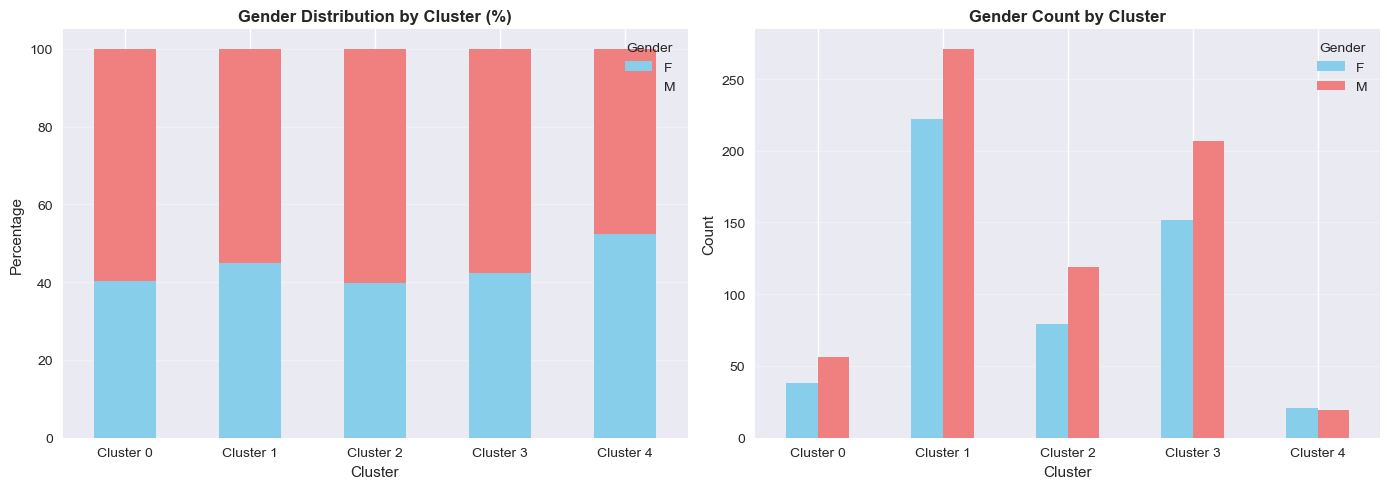

Gender Distribution by Cluster:
gender     F    M   All
cluster                
0         38   56    94
1        222  271   493
2         79  119   198
3        152  207   359
4         21   19    40
All      512  672  1184


In [18]:
# Gender distribution by cluster
gender_cluster = pd.crosstab(cluster_profiles['cluster'], cluster_profiles['gender'], normalize='index') * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar chart
gender_cluster.plot(kind='bar', stacked=True, ax=axes[0], color=['skyblue', 'lightcoral'])
axes[0].set_title('Gender Distribution by Cluster (%)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Cluster', fontsize=11)
axes[0].set_ylabel('Percentage', fontsize=11)
axes[0].set_xticklabels([f'Cluster {i}' for i in range(k_kmeans)], rotation=0)
axes[0].legend(title='Gender', fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# Count bar chart
gender_counts = pd.crosstab(cluster_profiles['cluster'], cluster_profiles['gender'])
gender_counts.plot(kind='bar', ax=axes[1], color=['skyblue', 'lightcoral'])
axes[1].set_title('Gender Count by Cluster', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Cluster', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_xticklabels([f'Cluster {i}' for i in range(k_kmeans)], rotation=0)
axes[1].legend(title='Gender', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Gender Distribution by Cluster:")
print(pd.crosstab(cluster_profiles['cluster'], cluster_profiles['gender'], margins=True))

Top 5 Diagnoses per Cluster:

Cluster 0 (n=131):
  1. Acute myocardial infarction: 29 (22.1%)
  2. Heart failure: 23 (17.6%)
  3. Atrial fibrillation and flutter: 19 (14.5%)
  4. Chronic ischemic heart disease: 6 (4.6%)
  5. Paroxysmal tachycardia: 4 (3.1%)

Cluster 1 (n=735):
  1. Acute myocardial infarction: 187 (25.4%)
  2. Heart failure: 122 (16.6%)
  3. Atrial fibrillation and flutter: 52 (7.1%)
  4. Chronic ischemic heart disease: 46 (6.3%)
  5. Nonrheumatic aortic valve disorders: 18 (2.4%)

Cluster 2 (n=292):
  1. Acute myocardial infarction: 57 (19.5%)
  2. Heart failure: 56 (19.2%)
  3. Chronic ischemic heart disease: 23 (7.9%)
  4. Atrial fibrillation and flutter: 20 (6.8%)
  5. Other diseases of pericardium: 9 (3.1%)

Cluster 3 (n=560):
  1. Acute myocardial infarction: 133 (23.8%)
  2. Heart failure: 79 (14.1%)
  3. Chronic ischemic heart disease: 42 (7.5%)
  4. Atrial fibrillation and flutter: 40 (7.1%)
  5. Other diseases of pericardium: 13 (2.3%)

Cluster 4 (n=68):
  1.

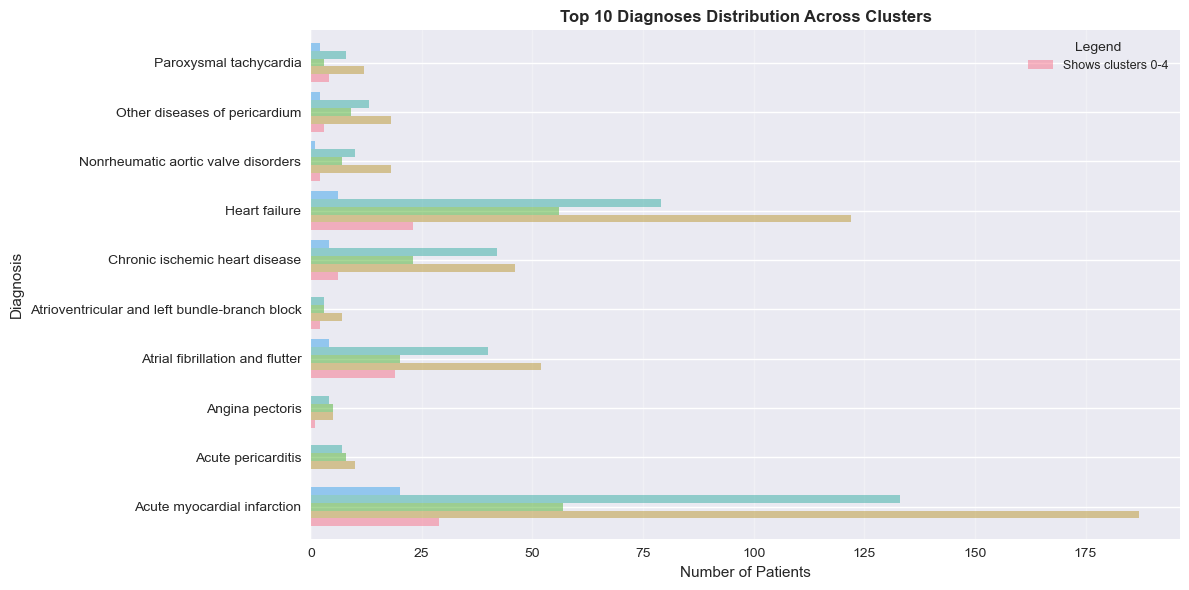

In [19]:
# Top diagnoses by cluster
print("Top 5 Diagnoses per Cluster:")
print("=" * 80)

for cluster_id in sorted(cluster_profiles['cluster'].unique()):
    cluster_diag = cluster_profiles[cluster_profiles['cluster'] == cluster_id]['long_title'].value_counts().head(5)
    print(f"\nCluster {cluster_id} (n={len(cluster_profiles[cluster_profiles['cluster'] == cluster_id])}):")
    for idx, (diag, count) in enumerate(cluster_diag.items(), 1):
        pct = (count / len(cluster_profiles[cluster_profiles['cluster'] == cluster_id])) * 100
        print(f"  {idx}. {diag}: {count} ({pct:.1f}%)")

# Visualize most common diagnoses across clusters
top_diag_overall = cluster_profiles['long_title'].value_counts().head(10).index.tolist()

fig, ax = plt.subplots(figsize=(12, 6))
diag_cluster = pd.crosstab(cluster_profiles['long_title'], cluster_profiles['cluster'])
diag_cluster_filtered = diag_cluster[diag_cluster.index.isin(top_diag_overall)]

diag_cluster_filtered.plot(kind='barh', ax=ax, width=0.8, alpha=0.5)
ax.set_title(f'Top 10 Diagnoses Distribution Across Clusters', fontsize=12, fontweight='bold')
ax.set_xlabel('Number of Patients', fontsize=11)
ax.set_ylabel('Diagnosis', fontsize=11)
ax.legend([f'Shows clusters 0-{k_kmeans-1}'], title='Legend', fontsize=9, loc='best')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

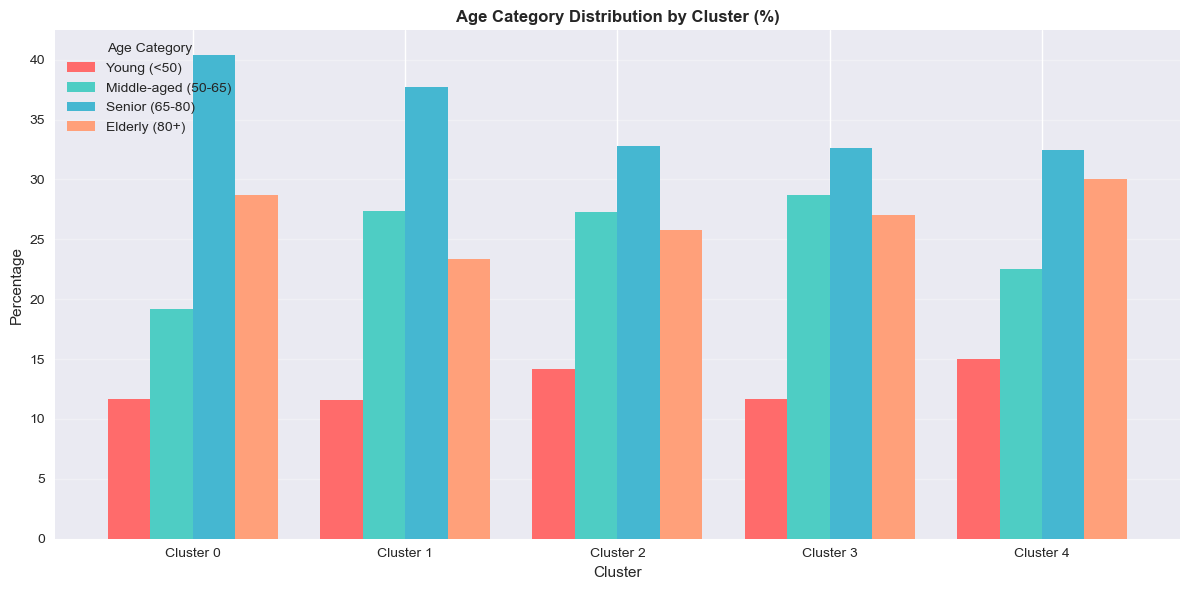

Age Category Distribution by Cluster:
age_category  Young (<50)  Middle-aged (50-65)  Senior (65-80)  Elderly (80+)  \
cluster                                                                         
0                      11                   18              38             27   
1                      57                  135             186            115   
2                      28                   54              65             51   
3                      42                  103             117             97   
4                       6                    9              13             12   
All                   144                  319             419            302   

age_category   All  
cluster             
0               94  
1              493  
2              198  
3              359  
4               40  
All           1184  


In [20]:
# Create age categories for easier interpretation
cluster_profiles['age_category'] = pd.cut(
    cluster_profiles['age'], 
    bins=[0, 50, 65, 80, 120], 
    labels=['Young (<50)', 'Middle-aged (50-65)', 'Senior (65-80)', 'Elderly (80+)']
)

# Age category distribution by cluster
age_cat_cluster = pd.crosstab(cluster_profiles['cluster'], cluster_profiles['age_category'], normalize='index') * 100

fig, ax = plt.subplots(figsize=(12, 6))
age_cat_cluster.plot(kind='bar', ax=ax, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'], width=0.8)
ax.set_title('Age Category Distribution by Cluster (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Cluster', fontsize=11)
ax.set_ylabel('Percentage', fontsize=11)
ax.set_xticklabels([f'Cluster {i}' for i in range(k_kmeans)], rotation=0)
ax.legend(title='Age Category', fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("Age Category Distribution by Cluster:")
print(pd.crosstab(cluster_profiles['cluster'], cluster_profiles['age_category'], margins=True))

### Cluster Summary

Cluster characteristics based on age, gender, and diagnosis patterns.

0     459
1    1001
2     126
3      68
4     132
Name: count, dtype: int64


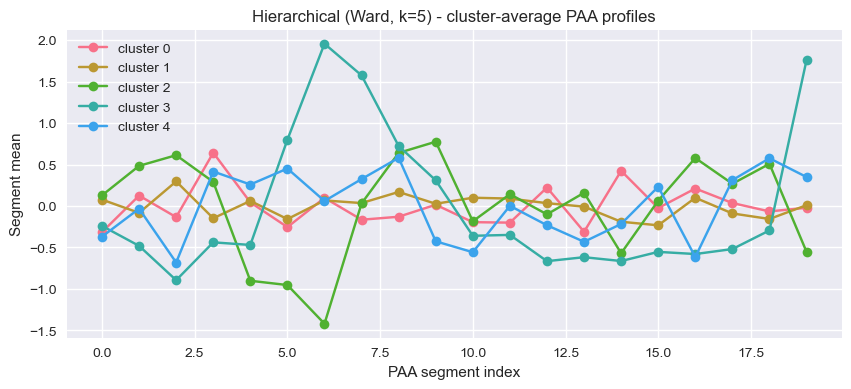

Silhouette score (Hierarchical, k=5): 0.231


In [21]:
# Hierarchical clustering (Ward linkage)

hier = AgglomerativeClustering(n_clusters=k_kmeans, linkage="ward")
hier_labels = hier.fit_predict(X_paa_scaled)

print(pd.Series(hier_labels).value_counts().sort_index())

plot_cluster_profiles(X_paa, hier_labels, f"Hierarchical (Ward, k={k_kmeans}) - cluster-average PAA profiles")

sil_hier = silhouette_score(X_paa_scaled, hier_labels)
print(f"Silhouette score (Hierarchical, k={k_kmeans}): {sil_hier:.3f}")

eps=0.5, min_samples=5 -> clusters=26, noise=955
eps=0.5, min_samples=10 -> clusters=25, noise=1067
eps=0.5, min_samples=20 -> clusters=14, noise=1327
eps=0.8, min_samples=5 -> clusters=28, noise=147
eps=0.8, min_samples=10 -> clusters=27, noise=168
eps=0.8, min_samples=20 -> clusters=27, noise=212
eps=1.0, min_samples=5 -> clusters=28, noise=62
eps=1.0, min_samples=10 -> clusters=28, noise=68
eps=1.0, min_samples=20 -> clusters=27, noise=89
eps=1.2, min_samples=5 -> clusters=29, noise=26
eps=1.2, min_samples=10 -> clusters=28, noise=35
eps=1.2, min_samples=20 -> clusters=28, noise=43
DBSCAN labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26]
-1     168
 0      62
 1      68
 2      62
 3      48
 4      55
 5      64
 6      62
 7      59
 8      75
 9      68
 10     44
 11     55
 12     63
 13     71
 14     54
 15     63
 16     53
 17     72
 18     49
 19     57
 20     61
 21     68
 22     66
 23     53
 24     39
 25     66
 26     6

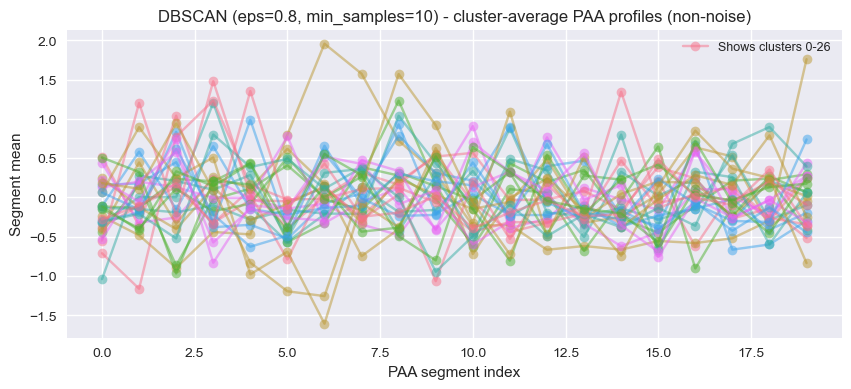

In [22]:
# DBSCAN clustering

# Try a couple of parameter combinations and inspect results
for eps in [0.5, 0.8, 1.0, 1.2]:
    for min_samples in [5, 10, 20]:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_paa_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = (labels == -1).sum()
        print(f"eps={eps}, min_samples={min_samples} -> clusters={n_clusters}, noise={n_noise}")

# Choose a reasonable combination after inspecting the above output
eps_db = 0.8
min_samples_db = 10

dbscan = DBSCAN(eps=eps_db, min_samples=min_samples_db)
dbscan_labels = dbscan.fit_predict(X_paa_scaled)

unique_db_labels = np.unique(dbscan_labels)
print("DBSCAN labels:", unique_db_labels)
print(pd.Series(dbscan_labels).value_counts().sort_index())

mask_non_noise = dbscan_labels != -1
if mask_non_noise.sum() > 0:
    # Get unique cluster labels (excluding noise -1)
    unique_clusters = np.unique(dbscan_labels[mask_non_noise])
    n_clusters_found = len(unique_clusters)
    min_cluster = int(unique_clusters.min())
    max_cluster = int(unique_clusters.max())
    
    # Create legend text
    if n_clusters_found > 1:
        legend_text = f"Shows clusters {min_cluster}-{max_cluster}"
    else:
        legend_text = f"Shows cluster {min_cluster}"
    
    plot_cluster_profiles(
        X_paa[mask_non_noise],
        dbscan_labels[mask_non_noise],
        f"DBSCAN (eps={eps_db}, min_samples={min_samples_db}) - cluster-average PAA profiles (non-noise)",
        alpha=0.5,
        legend_text=legend_text
    )
else:
    print("All points considered noise for current DBSCAN parameters.")

### Summary

**Preprocessing:** ECG Lead II → z-normalization → PAA (20 segments)

**Methods:**
- KMeans: Elbow method for k selection
- Hierarchical: Ward linkage, dendrogram
- DBSCAN: Density-based, identifies noise

PAA features only.